# Ch 9 - Advanced Topics in Probability and Statistics

This notebook contains python code for generating figures in the Chapter 9 of the book _Mathematics in Biology_.

In [1]:
import numpy as np
import random
from random import seed

from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import poisson, binom, t, norm, chi2, uniform, expon
from scipy import special

from mib.utils import plot, hist

# set font to be used in figures
import matplotlib.font_manager as font_manager
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'serif';
cmfont = font_manager.FontProperties(fname=matplotlib.get_data_path() + '/fonts/ttf/cmr10.ttf');
matplotlib.rcParams['font.serif']=cmfont.get_name();
matplotlib.rcParams['axes.formatter.use_mathtext'] = True
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['font.size'] = 11

Save = False # set to True if you are saving figures to a local drive
if Save:
    # set path to save the figures
    savedir = Path('../img')
    savedir.mkdir(parents=True, exist_ok=True)

datadir = Path('data')

Here we revisit the Luria & Delbrück study on the origin of mutations. Recall the basic structure of their experiment:

1. Grow a culture of bacteria to a total number of ~$10^8$
2. Expose the culture to a virus
3. Plate the culture and count the colonies. Each colony corresponds to a single mutant cell in the culture that is resistant to the virus.

They considered two basic hypotheses:

0. The mutations happen on exposure to the virus. Each bacterium has a small chance of mutating and thus surviving and forming a colony.
1. The mutations happened earlier throughout the growth of the culture, independent of the virus. Mutant cells pass the mutation on to their offspring. 

The null hypothesis $H_0$ predicts that the number of mutant cells in the culture should follow a Poisson distribution. If $n$ is the number of cells in the culture, and $\beta$ is the probability of mutation per cell, then the number of mutants $m$ follows

$$m \sim {\rm{Poiss}}(\beta \, n) $$

If one were to repeat the same experiment many times, the observed number of mutants should vary from trial to trial, and the variance of that result should be equal to the mean.

$${\rm{Var}}[m] = {\rm{E}}[m] $$

Instead, Luria & Delbrück found the variance was much larger. For example, in their Experiment 23 (Table 3) across 87 identical trials the mean number of mutants was 28.6 and the variance 6431, about 225 times larger than the mean. This is obviously inconsistent with the Poisson distribution, so one can reject the null hypothesis with a high degree of confidence. 
^[reference to Poisson test]

Here we want to see what their alternative hypothesis $H_1$ would predict.


Suppose the culture starts from a single bacterium and goes through $i$ successive rounds of mutation and cell division. In round $j=0,\dots,i-1$ there are $n_j = 2^j$ bacteria, and of these $m_j$ are already mutant. The remaining $n_j-m_j$ bacteria each experience a mutation with probability $\alpha$. We will call the number of new mutants $q_{j}$. Then all the bacteria divide to complete round $j$. Formally

$$m_{j+1} = 2 \, (m_j+q_{j})$$

where

$$q_{j} \sim {\rm{Binom}}(2^j-m_j,\alpha)$$

is binomially distributed. Starting with $m_0=0$ we want to understand the distribution of $m_i$, namely the final number of mutants.

This model is somewhat complex, because the distribution of $q_{j}$ depends on the outcome of all the preceding $q_k$. Surely it is easy to simulate the process, but one would like to get some analytical insight. A useful approximation is that the number of mutants in the culture is almost always very small. For example, in Experiment 23 the average was $\bar m_i = 28.6$ mutants out of a total of $n_i =  2.4 \times 10^8$ cells. So let us approximate $2^j-m_j \approx 2^j$, which means that all the bacteria present can undergo mutations (not just the non-mutants). Then

$$q_{j} \sim {\rm{Binom}}(2^j,\alpha)$$

which makes all the $q_{j}$ independent random variables and thus simplifies the problem. 

Now we can write

$$m_i = \sum_{j=}^{i-1} q_j 2^{i-j}$$

because the mutants arising in round $j$ then go through another $i-j$ rounds of division. This is a sum of independent random variables, so the expectation value and the variance simply sum. Note that

$${\rm{E}}[q_j] = \alpha \, 2^j$$

and

$${\rm{Var}}[q_j] = \alpha (1-\alpha ) \, 2^j$$

So the final number of mutants has expectation

$${\rm{E}}[m_i] = \sum_{j=0}^{i-1} {\rm{E}}[q_j] \, 2^{i-j} = i \, \alpha \, 2^i$$

and variance

$${\rm{Var}}[m_i] = \sum_{j=0}^{i-1} {\rm{Var}}[q_j] 2^{2(i-j)} = 2^j \alpha (1-\alpha) 2^{2(i-j)} = \alpha (1-\alpha) 2^{2i} \sum_{j=0}^{i-1} 2^{-j} = \alpha (1-\alpha) \, 2^{2i+1} (1-2^{-i})$$

We can further approximate $1-\alpha \approx 1$ because the mutation rate is small, and $1-2^{-i} \approx 1$ because there are many cell divisions, so that

$${\rm{Var}}[m_i] \approx \alpha \, 2^{2i+1}$$

Then the variance-to-mean ratio becomes

$$\frac{Var[m_i]}{E[m_i]} \approx \frac{2^{i+1}}{i}$$

Using the numbers from Experiment 23, $n_i =  2.4 \times 10^8$, so there were $i = \log_2 n_i \approx 28$ cell divisions. One therefore expects a variance-to-mean ratio of 

$\frac{Var[m_i]}{E[m_i]} \approx \frac{2^{i+1}}{i} \approx 2 \times 10^7$

Instead the authors report a variance-to-mean ratio of only ~200. So are the data really consistent with the alternative hypothesis of spontaneous mutation? It seems the observed variance-to-mean ratio violates the expectation from $H_1$ by an even bigger factor than the expectation from $H_0$.

To gain some insight it helps to experiment a bit, numerically of course. In simulating the process, we can perform the authors' Experiment 23 not once but many times. Here are the results:

100 Experiments with 87 cultures each
28 Cell divisions
Mutation rate 1.0e-08
Expected mean: 75.2
First 10 experiments:

    Mean       Var  Var/Mean
    37.1   16389.6     441.7
    22.4    3516.3     156.9
    22.2    3446.3     155.4
    36.6    9533.4     260.3
    22.3     840.6      37.7
    29.4    4695.5     159.7
    27.9    1161.7      41.6
    30.1    4653.5     154.8
    20.4    1291.7      63.2
    75.3  192515.6    2555.5


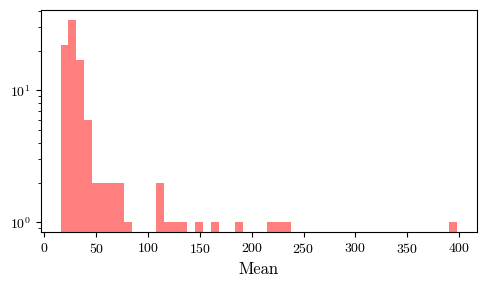

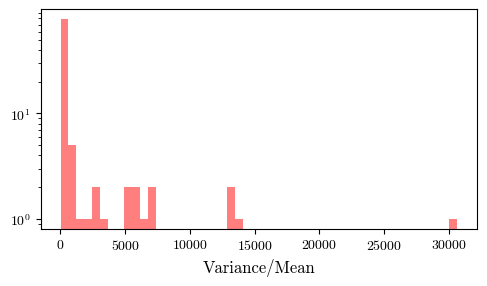

In [2]:
# simulate growth and mutation
def Sim(s,d,e,c,i,a):
    '''
    s=random seed
    d=number of rounds without mutation
    e=number of experiments
    c=number of cultures per experiment
    i=number of cell divisions
    a=mutation rate per bacterium per round of division
    '''
    np.random.seed(s)
    j=np.arange(i-d) # round
    n=2**(j+d) # number of bacteria in round j
    r=2**(i-j-d)
    m=np.array([[np.sum(np.random.binomial(n,a)*r) # number of mutants per culture
        for _ in range(c)] for _ in range(e)])    
    print('{} Experiments with {} cultures each'.format(e,c))
    print('{} Cell divisions'.format(i))
    print('Mutation rate {:.1e}'.format(a))
    if d>0:
        print('No mutations in first {} divisions'.format(d))
    print('Expected mean: {:.1f}'.format(a*(i-d)*2**i))
    print('First 10 experiments:')
    print('\n    Mean       Var  Var/Mean')
    for s in range(10):
        print('{:8.1f}  {:8.1f}  {:8.1f}'.
            format(np.mean(m[s]),np.var(m[s]),np.var(m[s])/np.mean(m[s])))
    M=np.mean(m,axis=-1)
    V=np.var(m,axis=-1)
    hist(M,
        xlabel='Mean',
         yscale='log',
    );
    hist(V/M,
        xlabel='Variance/Mean',
         yscale='log',
    );
    return M,V

M,V=Sim(2,0,100,87,28,1e-8)

Note both the mean and the variance/mean ratio scatter a lot. Also most of the time the sample mean is below the expectation. And the typical variance/mean ratio is closer to the value of ~225 reported by the authors. 

Both these statistics, the sample mean and the sample variance, have a highly skewed distribution, with a thin long tail extending to very large values. Those large values hardly ever happen. For example if the very first bacterium gets mutated that leads to a huge number of mutants in the final culture, but this will happen only once in $10^8$ cultures. Obviously one cannot sample all parts of this distribution experimentally.

To evaluate confidence limits on the Variance/Mean ratio predicted by the $H_1$ hypothesis, we can perform more experiments, and compute the cumulative distributions.

10000 Experiments with 87 cultures each
28 Cell divisions
Mutation rate 1.0e-08
Expected mean: 75.2
First 10 experiments:

    Mean       Var  Var/Mean
    37.1   16389.6     441.7
    22.4    3516.3     156.9
    22.2    3446.3     155.4
    36.6    9533.4     260.3
    22.3     840.6      37.7
    29.4    4695.5     159.7
    27.9    1161.7      41.6
    30.1    4653.5     154.8
    20.4    1291.7      63.2
    75.3  192515.6    2555.5


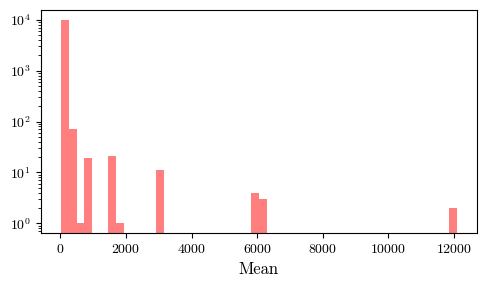

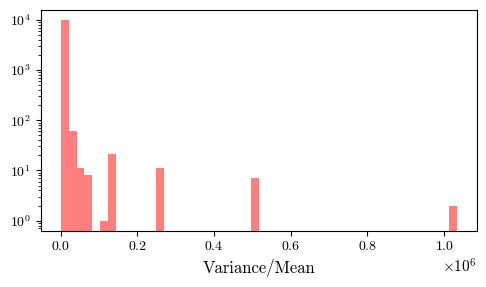

In [3]:
# More experiments, find 95% confidence limits
M,V=Sim(2,0,10000,87,28,1e-8)

In [4]:
# Distribution of the sample mean, from 10000 experiments
def plotMean(ax):
    Ms=np.sort(M)
    y=np.arange(len(Ms))/len(Ms)
    plot(Ms,y,
         fmts=['g-'],
        xscale='log',
         xlabel='Sample mean',
         ylabel='Cumulative',
        yticks=[0,1],
        axes=ax,
    );
    Q=[0.005,0.025,0.5,0.975,0.995]
    text='Quantile    Value'
    for q in Q:
        text+='\n{:8.3f} {:8.1f}'.format(q,Ms[np.where(y>q)[0][0]])
    ax.text(1e2,0.7,text,
            ha='left',
            va='top',
            family='monospace',
            fontsize=9,
);

In [5]:
# Distribution of the sample variance/mean, from 10000 experiments
def plotVar(ax):
    Vs=np.sort(V/M)
    y=np.arange(len(Vs))/len(Vs)
    plot(Vs,y,
        xscale='log',
         xlabel='Sample variance / mean',
        #  ylabel='Cumulative',
         yticks=[0,1],
         xticks=[1e1,1e2,1e3,1e4,1e5,1e6],
         axes=ax,
    );
    Q=[0.005,0.025,0.5,0.975,0.995]
    text='Quantile    Value'
    for q in Q:
        text+='\n{:8.3f} {:8.1f}'.format(q,Vs[np.where(y>q)[0][0]])
    ax.text(1e3,0.7,text,
            ha='left',
            va='top',
            family='monospace',
            fontsize=9,
    );


Summary

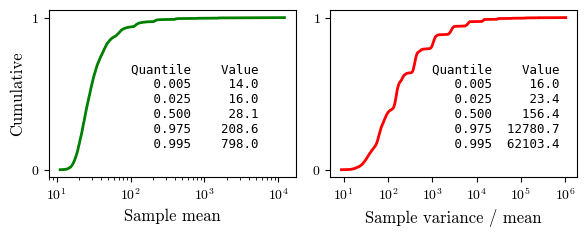

In [6]:
# Both plots together
fig,ax=plt.subplots(1,2,figsize=(6,2.5))
plotMean(ax[0]);
plotVar(ax[1]);
fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'inf-LD-conf-lim.pdf'), dpi=600, format='pdf', bbox_inches='tight');

Note the logarithmic x-axis. These values span a very large range.

Presumably the steps visible in the Variance/Mean cumulative correspond to mutations occurring in earlier and earlier generations. Note the steps get shallower, because there are fewer bacteria in earlier generations. But they span about the same log range of Variance/Mean.

Regarding the viability of hypothesis $H_1$: The value of 225 reported by L&D lies right in the bulk of the distribution, at a cumulative of ~0.6. So the p-value is ~0.4, and one concludes that the observed results are in fact compatible with the alternative hypothesis $H_1$.

Beyond the issue of hypothesis testing, this example also illustrates the care required when dealing with extremely skewed distributions, where the mean and variance do not reflect where most of the values are located. Recall that for this distribution

$\frac{Var[m_i]}{E[m_i]} \approx \frac{2^{i+1}}{i} \approx 2 \times 10^7$

and yet a sample of size 87 will produce a Var/Mean ratio that lies in the interval [16,62000] 99% of the time. 

### Quantization of continuous variables


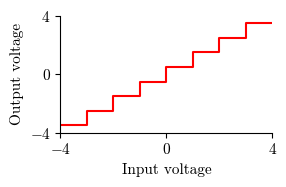

In [7]:
x = np.arange(-4,5,1)
x = x.repeat(2)[1:-1]

y = np.arange(-3.5,4.5,1)
y = y.repeat(2)
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(x,y,'r');
ax.set_ylim([-4,4]);
ax.set_yticks([-4,0,4]);
ax.set_xlim([-4,4]);
ax.set_xticks([-4,0,4]);
ax.set_xlabel('Input voltage');
ax.set_ylabel('Output voltage');
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'quantizer.pdf'), dpi=600, format='pdf', bbox_inches='tight');

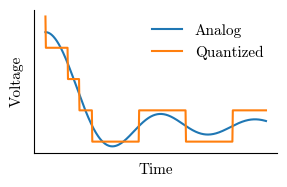

In [8]:
# domain
x = np.linspace(0,3*np.pi/2,500)
# signal (sinc function)
y = 3*np.sinc(x)
# quantized signal
z = np.zeros(y.shape)
for i in np.arange(len(y)):
    if y[i]>=-4 and y[i]<-3:
        z[i] = -3.5
    elif y[i]>=-3 and y[i]<-2:
        z[i] = -2.5
    elif y[i]>=-2 and y[i]<-1:
        z[i] = -1.5
    elif y[i]>=-1 and y[i]<0:
        z[i] = -0.5
    elif y[i]>=0 and y[i]<1:
        z[i] = 0.5
    elif y[i]>=1 and y[i]<2:
        z[i] = 1.5
    elif y[i]>=2 and y[i]<3:
        z[i] = 2.5
    elif y[i]>=3 and y[i]<4:
        z[i] = 3.5
    else:
        z[i] = 0
# plot both
fig,ax = plt.subplots(figsize=(3,2))
ax.plot(x,y,label='Analog');
ax.plot(x,z,label='Quantized');
ax.legend(frameon=False);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# remove x ticks
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_xlabel('Time');
ax.set_ylabel('Voltage');
fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'quantized.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Fluctuation analysis

In [9]:
# Generate on and off transitions as a point process
def tel(a01,a10,du,rs):
    '''
    du=duration in s
    a01,a10=on and off rates in 1/s
    rs=random seed
    returns 
    t01,t10=times of on and off transitions
    '''
    np.random.seed(rs)
    p=a01/(a01+a10) # on probability
    t=0
    t01=[]
    t10=[]
    if np.random.uniform()<p: # start with open
        t=np.random.exponential(1/a10)
        if t<du:
            t10+=[t]
    while True:
        t+=np.random.exponential(1/a01)
        if t>du:
            break
        t01+=[t]
        t+=np.random.exponential(1/a10)
        if t>du:
            break
        t10+=[t]

    return t01,t10
        

In [10]:
t01,t10=tel(2,1,10,0)    

In [11]:
# Generate on and off transitions as a time series
def tel2(a01,a10,du,dt,rs):
    '''
    a01,a10=on and off rates in 1/s
    du=duration in s
    dt=time resolution in s
    rs=random seed
    returns
    y=time series
    '''
    t01,t10=tel(a01,a10,du,rs) # lists of on and off times
    t=np.linspace(0,du,int(du/dt)+1) # bins for histogram
    y01,_=np.histogram(t01,bins=t) # histogram on times
    y10,_=np.histogram(t10,bins=t) # histogram off times
    y=np.cumsum(y01-y10) # running sum
    if t10[0]<t01[0]: # if channel is open at the start
        y+=1    
    return y

In [12]:
# simulate
n=1000 # number of channels
du=100 # duration in s
a01=1/0.1 # on rate in 1/s
a10=1/0.2 # off rate in 1/s
dt=0.001 # time resolution in s
t=np.linspace(0,du,int(du/dt)) # time axis

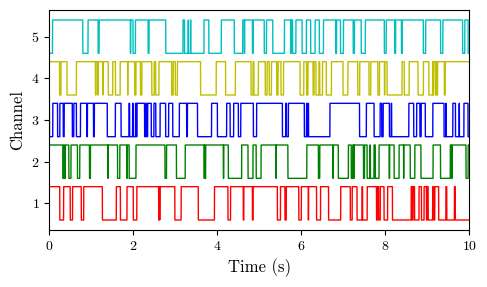

In [13]:
# show m channels
m=5
Y=np.array([tel2(a01,a10,du,dt,rs)*0.8+0.6+rs for rs in range(m)]) # different random seeds
plot(t,Y,xlabel='Time (s)',ylabel='Channel',xlim=[0,10],linewidth=1);

In [14]:
# # sum n trials
# n=1000
# S=np.array(tel2(a01,a10,du,dt,rs=0))
# for rs in range(1,n):
#     S+=tel2(a01,a10,du,dt,rs)

In [15]:
# sum n trials faster; accumulate all the on and off times across channels, then compute running sum
n=1000
T01=[];T10=[];y0=0
for rs in range(1,n):
    t01,t10=tel(a01,a10,du,rs)
    if t10[0]<t01[0]: # if channel is open at start
        y0+=1
    T01+=t01;T10+=t10
bins=np.linspace(0,du,int(du/dt)+1)
y01,_=np.histogram(T01,bins=bins)
y10,_=np.histogram(T10,bins=bins)
S=np.cumsum(y01-y10)+y0

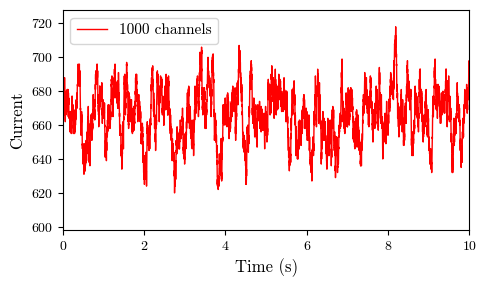

In [16]:
plot(t,S,xlabel='Time (s)',ylabel='Current',legend=['1000 channels'],xlim=[0,10],linewidth=1);

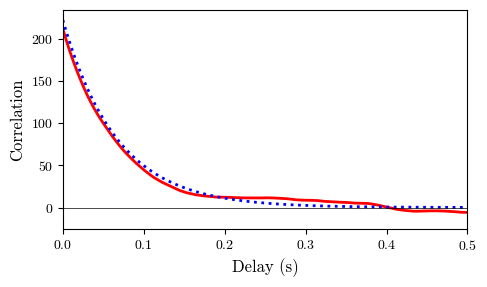

In [17]:
# autocorrelation function, simulated and theory
from scipy.fftpack import fft, ifft
p=a01/(a01+a10) # open probability
S1=S-p*n # subtract the mean current
C=np.real(ifft(np.abs(fft(S1))**2))/du*dt # autocorrelate
V=n*p*(1-p) # theoretical variance, i.e. autocorrelation at zero delay
y=V*np.exp(-(a01+a10)*t) # theoretical autocorrelation
plot(t,[C,y],yzero=True,fmts=['r-','b:'],xlabel='Delay (s)',ylabel='Correlation',
    xlim=[0,0.5]);

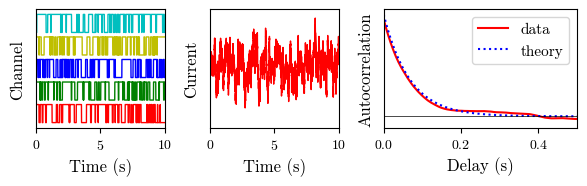

In [18]:
fig,ax=plt.subplots(1,3,figsize=(6,2),gridspec_kw={'width_ratios':[1,1,1.5]})
plot(t,Y,xlabel='Time (s)',ylabel='Channel',xlim=[0,10],linewidth=1,axes=ax[0]);
ax[0].set_yticks([])
plot(t,S,xlabel='Time (s)',ylabel='Current',
    #  legend=['1000 channels'],
     xlim=[0,10],
     linewidth=1,axes=ax[1]);
ax[1].set_yticks([])
plot(t,[C,y],yzero=True,fmts=['r-','b:'],xlabel='Delay (s)',ylabel='Autocorrelation',
    linewidth=1.5,xlim=[0,0.5],legend=['data','theory'],axes=ax[2]);
ax[2].set_yticks([])
# ax[2].set_yticklabels(['0','',''])
# plt.tight_layout()
fig.subplots_adjust(wspace=0.3)
if Save:
    fig.savefig(str(savedir / 'fluct-anal.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Population and quantitative genetics

#### Genetic drift

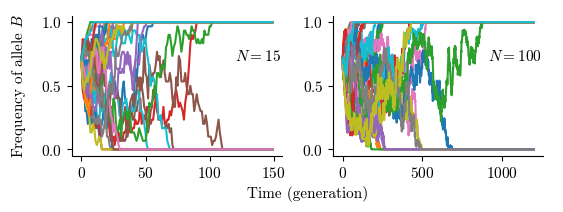

In [19]:
def simulate_genetic_drift(n, t, p=0.7, seed=4):
    x = np.zeros((t, n))

    x[0] = np.concatenate((np.ones((int(n*p))), np.zeros(n-int(n*p))))

    rng = np.random.default_rng(seed)

    for i in range(1, t):
        x[i] = rng.choice(x[i-1], size=n, replace=True)
    return x

fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(6,2.5))

N = 30

n = 30
t = 150
p = 0.7
for i in range(N):
    x = simulate_genetic_drift(n, t, p, seed=i)
    axes[0].plot(np.mean(x,axis=1))

axes[0].text(120, 0.7, f"$N={int(n/2)}$")

n = 200
t = 1200
p = 0.7
for i in range(N):
    x = simulate_genetic_drift(n, t, p, seed=i)
    axes[1].plot(np.mean(x,axis=1))

axes[1].text(910, 0.7, f"$N={int(n/2)}$")
    
# add a big axis, hide frame
big_ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
big_ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
big_ax.set_ylabel("Frequency of allele $B$");
big_ax.set_xlabel("Time (generation)");

axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'genetic_drift.pdf'), dpi=600, format='pdf', bbox_inches='tight');

#### Selection

C:\Users\Younes\AppData\Local\Temp\ipykernel_8056\1852528478.py:46: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axes[1,1].get_shared_x_axes().join(axes[1,1], axes[0,1])
C:\Users\Younes\AppData\Local\Temp\ipykernel_8056\1852528478.py:56: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axes[0,0].get_shared_y_axes().join(axes[0,0], axes[0,1])


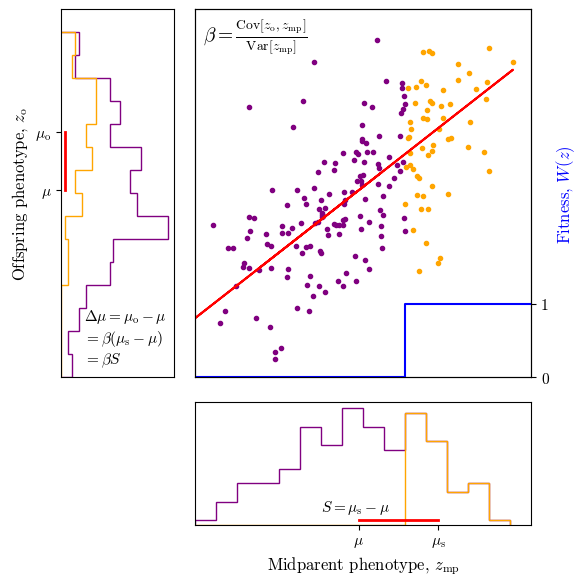

In [20]:
theta = np.pi/4
L = np.array([[4,0],[0,1]])
U = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])

n = 1000

rng = np.random.default_rng(seed=53)
x = rng.multivariate_normal(mean=[4,4], cov=np.matmul(np.matmul(U,L),U.T), size=200)

threshold = 5

fig, axes = plt.subplots(ncols=2,nrows=2,figsize=(6,6),
                         gridspec_kw={'width_ratios':[1,3],'height_ratios':[3,1]})

axes[1,0].axis('off')

# breeders eq
axes[0,1].plot(x[x[:,0]<threshold,0],x[x[:,0]<threshold,1], 'o', color='purple', markersize=3)
axes[0,1].plot(x[x[:,0]>=threshold,0],x[x[:,0]>=threshold,1], 'o', color='orange', markersize=3)
axes[0,1].get_xaxis().set_ticks([])
axes[0,1].get_yaxis().set_ticks([])

axes[0,1].set_xlim([0,8])
axes[0,1].set_ylim([0,8])

# linear regression
A = np.vstack([x[:,0], np.ones(len(x[:,0]))]).T
m, c = np.linalg.lstsq(A, x[:,1], rcond=None)[0]
axes[0,1].plot(x[:,0], m*x[:,0] + c, 'r')

# fitness
ax2 = axes[0,1].twinx()
ax2.plot([0,threshold,threshold,8], [0,0,0.2,0.2],color='blue')
ax2.set_ylabel('Fitness, $W(z)$', color='blue', fontsize=12)
ax2.set_ylim([0,1])
ax2.set_yticks([0,0.2])
ax2.set_yticklabels([0,1])

# parental population
axes[1,1].hist(x[:,0],bins=np.arange(0,8,0.5), histtype='step', color='purple')
axes[1,1].hist(x[x[:,0]>threshold,0], bins=np.arange(0,8,0.5), histtype='step', color='orange')
axes[1,1].set_xlabel("Midparent phenotype, $z_\mathrm{mp}$", fontsize=12)
axes[1,1].set_xticks([np.mean(x[:,0]), np.mean(x[x[:,0]>threshold,0])])
axes[1,1].set_xticklabels(["$\mu$", "$\mu_\mathrm{s}$"])
axes[1,1].set_xlim([0,8])
axes[1,1].get_shared_x_axes().join(axes[1,1], axes[0,1])
axes[1,1].get_yaxis().set_ticks([])

# offspring population
axes[0,0].hist(x[:,1], orientation='horizontal', bins=np.arange(0,8,0.5), histtype='step', color='purple')
axes[0,0].hist(x[x[:,0]>threshold,1], orientation='horizontal', bins=np.arange(0,8,0.5), histtype='step', color='orange')
axes[0,0].set_ylabel("Offspring phenotype, $z_\mathrm{o}$", fontsize=12)
axes[0,0].set_yticks([np.mean(x[:,1]), np.mean(x[x[:,0]>threshold,1])])
axes[0,0].set_yticklabels(["$\mu$", "$\mu_\mathrm{o}$"])
axes[0,0].set_ylim([0,8])
axes[0,0].get_shared_y_axes().join(axes[0,0], axes[0,1])
axes[0,0].get_xaxis().set_ticks([])

# text label
axes[1,1].plot([np.mean(x[:,0]), np.mean(x[x[:,0]>threshold,0])], [1,1], 'r', linewidth=2)
axes[1,1].text(3, 3, "$S=\mu_\mathrm{s} - \mu$", fontsize=11) 

axes[0,0].plot([1,1], [np.mean(x[:,1]), np.mean(x[x[:,0]>threshold,1])], 'r', linewidth=2)
axes[0,0].text(6.5, 0.3, r"$\Delta \mu =\mu_\mathrm{o} - \mu$" + "\n" + r"$= \beta(\mu_\mathrm{s} - \mu)$" + "\n" + r"$= \beta S$", fontsize=11) 

axes[0,1].text(0.2,7.3,r"$ \beta = \frac{ \mathrm{Cov}[z_\mathrm{o}, z_\mathrm{mp}] }{ \mathrm{Var}[z_\mathrm{mp}] }$", fontsize=14)

fig.tight_layout()

if Save:
    fig.savefig(str(savedir / 'selection.pdf'), dpi=600, format='pdf', bbox_inches='tight');
    fig.savefig(str(savedir / 'selection.svg'), dpi=600, format='svg', bbox_inches='tight');

### Neuroscience

In [21]:
# Setup
T=1 # duration in s
dt=0.001 # time resolution in s
n=int(T/dt) # number of time points
t=np.linspace(0,T,n)
np.random.seed(1)
# Gaussian stimulus, low-pass filtered
tlo=0.1 # tau of low-pass filter in s
flo=np.exp(-t/tlo) # impulse response of low-pass filter
ifl=np.random.normal(0,1,size=n) # white noise waveform for the fluctuating input
s=np.convolve(ifl,flo)[0:n] # convolve white noise with low-pass filter

# kernel
n=3 # power of rising phase
tau=0.02 # time constant
u=1 # degree of undershoot
k=((t/tau)**n-u*(t/tau)**(n+1)/(n+1))*np.exp(-t/tau)

# filtered stimulus
f=np.convolve(s,k,mode='full')[:len(s)]*dt

# nonlinearity
wid=0.1 # width of the sigmoid
thr=0.2 # threshold
mar=100 # max rate
def N(x):
    return mar*0.5*(1+np.tanh((x-thr)/wid))
x=np.linspace(thr-4*wid,thr+4*wid,100)

#response
R=N(f)


#### Simulating a variable-rate Poisson process
Using the above result one can easily simulate a variable rate Poisson process with rate $R(t)$ over the interval $t \in [0,T]$

1. Define the warped time

$$u(t)=\int_{0}^{t} R(t') {\rm{d}}t'$$

which ranges $u \in [0,U]$, where $U=u(T)$.

2. Create a uniform Poisson process on the interval $[0,U]$:

a. Choose the number of events $n$ by drawing from the Poisson distribution

$$n \sim {\rm{Pois}}(U)$$

b. Sample $n$ event times uniformly from the interval $[0,U]$, namely

$$u_i \sim {\rm{Unif}}(0,U), \quad i=1,\dots,n$$

c. Transform to regular time $t$ using the inverse of the warp function $u(t)$:

$$t_i = u^{-1}(u_i), \quad i=1,\dots,n$$

In general the inversion has to be done numerically.

In [22]:
def var_poiss(T,R,n,s):
    '''
    Samples a variable rate Poisson process
    T = duration of the process
    R = instantaneous rate (array from t=0 to t=T)
    n = number of trials to simulate
    s = random seed
    Returns: n lists of spike times, one for each trial
    '''
    from scipy import interpolate
    dt=T/(len(R)-1) # time resolution
    t=np.linspace(0,T,len(R)) # time axis
    u=np.insert(np.cumsum((R[:-1]+R[1:])/2),0,0)*dt # integrate rate to get warp time
    U=u[-1] # duration in warp time
    f=interpolate.interp1d(u,t) # inverse function u^-1
    np.random.seed(s) # set random seed
    m=np.random.poisson(U,n) # number of events in each trial
    return [f(np.random.uniform(0,U,k)) for k in m] # list of arrays of event times

#### Example: sinusoid rate modulation
Here we produce a variable rate Poisson process with instantaneous rate $R(t)=a(1+m \sin\omega t)$.

In [23]:
a=10 # average rate in s^-1
m=0.5 # relative modulation
p=2 # period in seconds
om=2*np.pi/p # angular frequency
T=10 # duration in s
s=100 # number of trials

dt=0.001 # time resolution in s
x=np.linspace(0,T,int(T/dt)) # time
R=a*(1+m*np.sin(om*x)) # rate
t=var_poiss(T,R,s,0) # rate-modulated spike trains

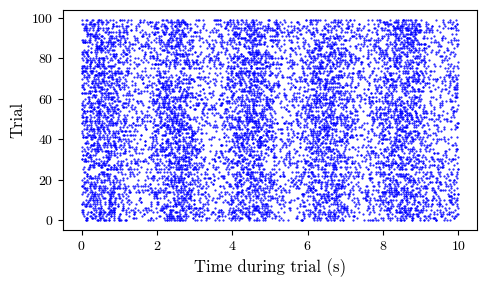

In [24]:
# raster graph
j=[np.full(len(tk),k) for k,tk in enumerate(t)] # trial number for each spike
y=np.concatenate(j) # single array of all trial numbers
x=np.concatenate(t) # single array of all spike times
plot(x,y,
     fmts=['b.',],
     markersize=1,
     xlabel='Time during trial (s)',
     ylabel='Trial'
); 

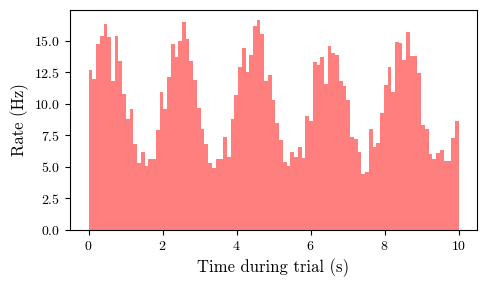

In [25]:
# PSTH
nbins=100 # number of bins in the histogram
hist(x,bins=np.linspace(0,T,nbins),
     ylabel='Rate (Hz)',xlabel='Time during trial (s)',
     weights=np.full(len(x),nbins/T/s), # normalize to a firing rate
);

#### The Linear-Nonlinear model of neural encoding

In [26]:
# Setup
T=1 # duration in s
dt=0.001 # time resolution in s
n=int(T/dt) # number of time points
t=np.linspace(0,T,n)
np.random.seed(1)
# Gaussian stimulus, low-pass filtered
tlo=0.1 # tau of low-pass filter in s
flo=np.exp(-t/tlo) # impulse response of low-pass filter
ifl=np.random.normal(0,1,size=n) # white noise waveform for the fluctuating input
s=np.convolve(ifl,flo)[0:n] # convolve white noise with low-pass filter

# kernel
n=3 # power of rising phase
tau=0.02 # time constant
u=1 # degree of undershoot
k=((t/tau)**n-u*(t/tau)**(n+1)/(n+1))*np.exp(-t/tau)

# filtered stimulus
f=np.convolve(s,k,mode='full')[:len(s)]*dt

# nonlinearity
wi=0.1 # width of the sigmoid
th=0.2 # threshold
mr=100 # max rate
def N(x):
    return mr*0.5*(1+np.tanh((x-th)/wi))
x=np.linspace(th-4*wi,th+4*wi,100)

#response
R=N(f)

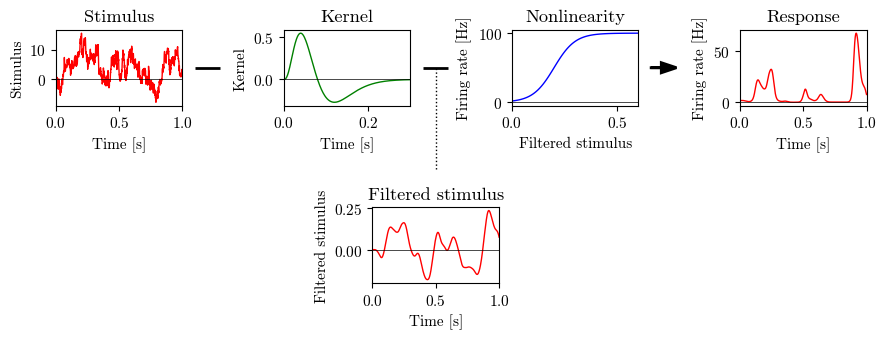

In [27]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(9,3.5),rasterized=True)
ax1 = ax.inset_axes([0, 9, 10, 6], transform = ax.transData)
ax1.plot(t,s,'r',linewidth=1)
ax1.plot([0,1],[0,0],'k',linewidth=0.5)
ax2 = ax.inset_axes([18, 9, 10, 6], transform = ax.transData)
ax2.plot(t,k,'g',linewidth=1)
ax2.plot([0,1],[0,0],'k',linewidth=0.5)
ax3 = ax.inset_axes([36, 9, 10, 6], transform = ax.transData)
ax3.plot(x,N(x),'b',linewidth=1)
ax3.plot([0,1],[0,0],'k',linewidth=0.5)
ax4 = ax.inset_axes([54, 9, 10, 6], transform = ax.transData)
ax4.plot(t,R,'r',linewidth=1)
ax4.plot([0,1],[0,0],'k',linewidth=0.5)
ax5 = ax.inset_axes([25, -5, 10, 6], transform = ax.transData)
ax5.plot(t,f,'r',linewidth=1)
ax5.plot([0,1],[0,0],'k',linewidth=0.5)

ax1.set_xlabel('Time [s]');
ax1.set_ylabel('Stimulus');
ax1.set_title('Stimulus');
ax1.set_xlim([0,1])

ax2.set_xlabel('Time [s]');
ax2.set_ylabel('Kernel');
ax2.set_title('Kernel');
ax2.set_xlim([0,0.3])

ax3.set_xlabel('Filtered stimulus');
ax3.set_ylabel('Firing rate [Hz]');
ax3.set_title('Nonlinearity');
ax3.set_xlim([0,0.6])

ax4.set_ylabel('Firing rate [Hz]');
ax4.set_xlabel('Time [s]');
ax4.set_title('Response');
ax4.set_xlim([0,1])

ax5.set_ylabel('Filtered stimulus');
ax5.set_xlabel('Time [s]');
ax5.set_title('Filtered stimulus');
ax5.set_xlim([0,1])

ax.set_xlim(0,64)
ax.set_ylim(-5,15)
ax.set_aspect('equal')
ax.axis('off')

ax.arrow(47,12,2,0,width=0.01,length_includes_head=True,head_width=0.8,
                overhang=0,color='k',linewidth=2)
ax.arrow(29,12,2,0,width=0.01,length_includes_head=True,head_width=0,
                overhang=0,color='k',linewidth=2)
ax.arrow(11,12,2,0,width=0.01,length_includes_head=True,head_width=0,
                overhang=0,color='k',linewidth=2)
ax.plot([30,30],[4,12],'k',linewidth=1,linestyle='dotted')

fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'LN-Model.pdf'), dpi=600, format='pdf', bbox_inches='tight');

In [28]:
tr=100 # number of trials
q=var_poiss(T,R,tr,0) # rate-modulated spike trains

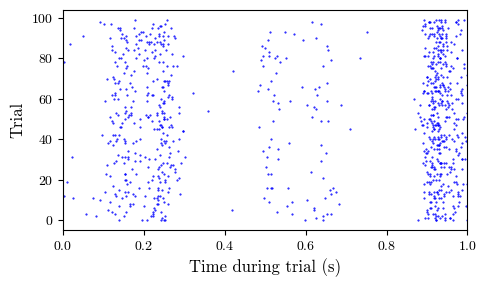

In [29]:
# raster graph
j=[np.full(len(qk),k) for k,qk in enumerate(q)] # trial number for each spike
y=np.concatenate(j) # single array of all trial numbers
x=np.concatenate(q) # single array of all spike times
plot(x,y,
     fmts=['b.',],
     markersize=1,
     xlabel='Time during trial (s)',
     ylabel='Trial',
     xlim=[0,1],
); 

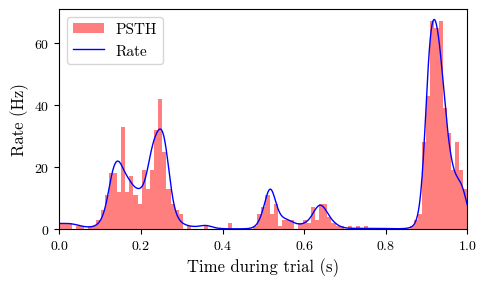

In [30]:
# PSTH
nbins=100 # number of bins in the histogram
ax,_,_,_=hist(x,bins=np.linspace(0,1,nbins),
     ylabel='Rate (Hz)',xlabel='Time during trial (s)',
     weights=np.full(len(x),nbins/T/tr), # normalize to a firing rate
     xlim=[0,1],
)
plot(t,R,axes=ax,fmts=['b-'],linewidth=1,legend=['PSTH','Rate']);

## Exercises

### Reverse correlation from H1 data

Here we analyze the sensory responses of a visual neuron in the fly that is called "H1". This neuron is part of the flight control system of the fly. To stabilize its flight, the fly most measure its own rotation relative to the world. It does that largely by analyzing full-field motion on its retina, also called optic flow. Neuron H1 seems to encode the optical flow in the horizontal direction. More information about the H1 neuron can be found here: https://en.wikipedia.org/wiki/H1_neuron.

We will work with a neural recording from neuron H1. In this experiment the fly was fixed in the lab frame, and presented with a visual pattern that moved back and forth in the horizontal direction. The velocity of that pattern was modulated with a Gaussian distribution. The data file contains a record of the stimulus velocity and a record of all the spikes fired by neuron H1. 

Your task is to find out how neuron H1 encodes the velocity stimulus. In particular:
- What is the delay between the visual inout and the neuron's response? This is a critical chracteristic for a real-time control system.
- What is the time resolution of the neuron? Are there fluctuations in the sitmulus too fast for the neuron to resolve?

Apply the LN model to the neuron's responses, as discussed in section \@ref{LN-model}. In particular, compute the filter $L(t)$ using reverse correlation between stimulus and response. The shape of $L(t)$ will offer answers to the above questions.

Details:

1. Load the data from the `data/` directory associated with this book:

In [31]:
# load stimulus and response
import pickle
file_name = 'data/H1_neuron_t_in_ms.pickle'
with open(file_name, 'rb') as f:
    s,r = pickle.load(f)

The array $s$ contains a time series of the stimulus (in arbitrary units), with one sample per ms. The array $r$ contains the corresponding spike train from H1 in bins of width 1 ms. Each bin contains at most 1 spike. 

2. Compute a histogram of the stimulus. Compare that to a Gaussian. Recall that a Gaussian stimulus is useful for interpretation of the reverse correlation.

3. Compute the reverse correlation function. Because the response is sparse, i.e. only a small fraction of the time bins contain a spike, you may benefit from converting the time series to a point process, and using the "spike-triggered average" formulation of the reverse correlation. For a start, use a stimulus window of [-0.5 s, +0.5 s] relative to the spike.

4. Interpret the shape of the reverse correlation to answer the above questions.

5. Bonus question: Estimate the nonlinearity $N(f)$ in the LN model of this neuron's response.

### Solution

MM Note: The data file is derived from an assignment from U Washington, see https://github.com/abaybektursun/neural_encoding_H1. That repo also has code, but not very pretty.

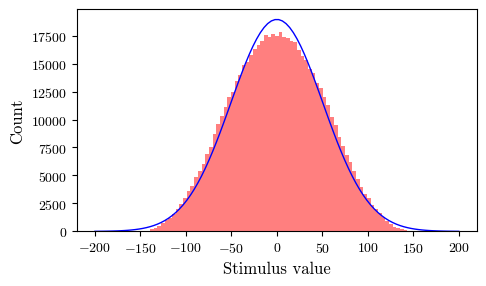

In [32]:
# histogram the stimulus, compare to a Gaussian
x=np.linspace(-200,200,100)
sig=np.std(s)
ax,_,_,_=hist(s,bins=x);
plot(x,1/np.sqrt(2*np.pi)/sig*4*len(s)*np.exp(-x**2/2/sig**2),
     fmts=['b-'],linewidth=1,axes=ax,
    xlabel='Stimulus value',
    ylabel='Count',);

Pretty close to a Gaussian distribution but not exact.

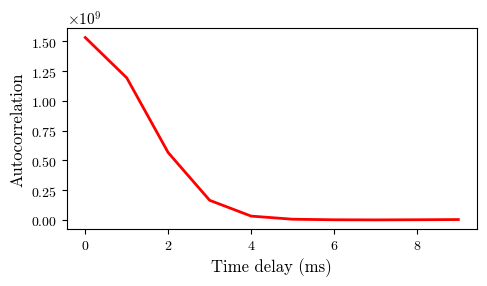

In [33]:
# check stimulus autocorrelation, use FFT because big array
from scipy.fftpack import fft, ifft
a=np.real(ifft(np.abs(fft(s))**2))

plot(a[:10],xlabel='Time delay (ms)',ylabel='Autocorrelation');

OK, correlations reaching out to 2 ms or so. So we can't expect to see structure in the STA below 2 ms.


In [34]:
# extract spike times from response time series
t=r.nonzero()[0]

In [35]:
# set up the reverse correlation
lo=-500; hi=500 # window of the rev cor in ms relative to the spike
jl=np.where(t>-lo)[0][0] # first useful spike
jh=np.where(t>len(r)-hi)[0][0] # last useful spike

In [36]:
# compute rev cor
c=np.mean([s[x+lo:x+hi] for x in t[jl:jh]],axis=0)

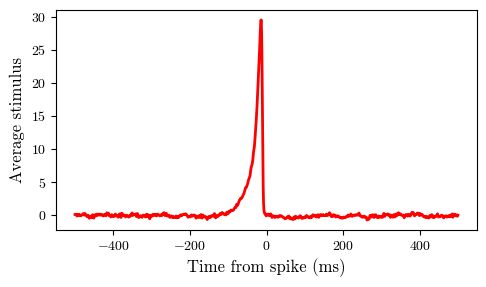

In [37]:
# plot rev cor
plot(np.arange(lo,hi),c,
     xlabel='Time from spike (ms)',ylabel='Average stimulus');

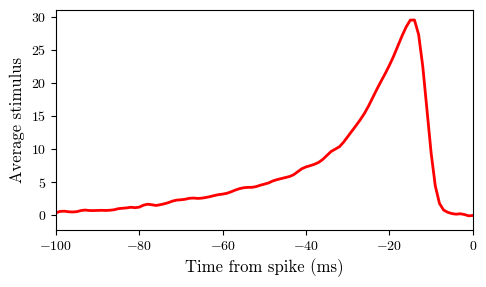

In [38]:
# zoom in
plot(np.arange(lo,hi),c,xlim=[-100,0],
    xlabel='Time from spike (ms)',ylabel='Average stimulus');

**Answers**
- Time delay is about 10 ms: from the spike back to the steep rise of the STA.
- Time resolution is about 20 ms, e.g. measured by FWHM of the STA. Could also do an exponential fit to the tail of the STA

Compare to de Ruyter & Bialek 1988:
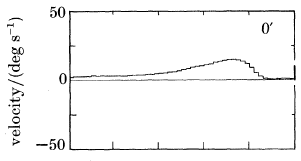
where the tick marks are 20 ms.
Looks like this is a slightly different data set.

### Nonlinearity
Scheme:
- compute filtered stimulus = f(t)
- histogram its values = n0
- histogram its spike-triggered values = n1
- divide n1/n0 to get the firing probability per bin as a function of f

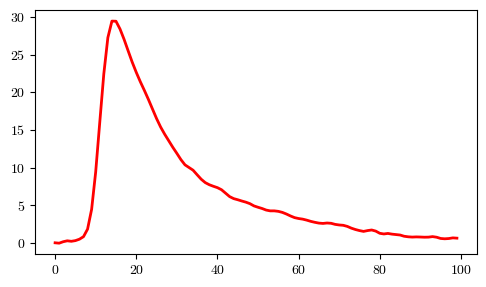

In [39]:
# set the kernel to the time-reverse of the STA. use only 100 ms of the STA.
L=c[500:400:-1]
plot(L);

In [40]:
# convolve stimulus with kernel
f=np.convolve(s,L,mode='full')[:len(s)]

In [41]:
# normalize the filtered stimulus to unit std dev; this is not necessary but convenient
f/=np.std(f)

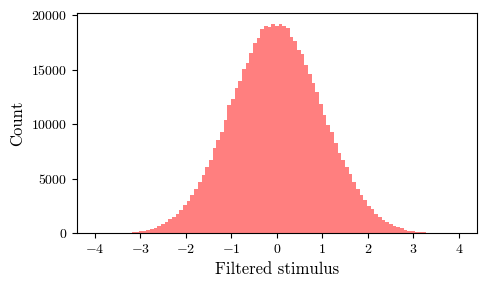

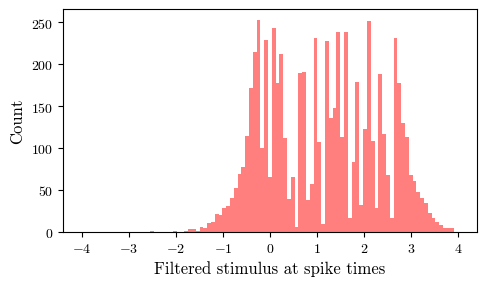

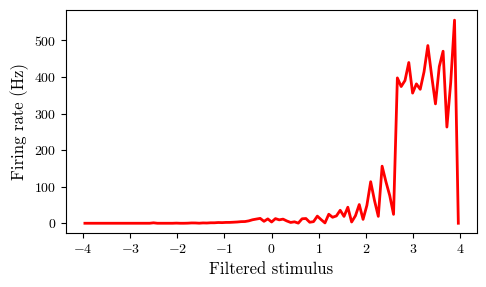

In [42]:
# histogram the filtered stimulus and its spike-triggered version
b=np.linspace(-4,4,100) # bin boundaries span ±4 sigma
_,n0,_,_=hist(f,bins=b, # filtered stimulus in all time bins
    xlabel='Filtered stimulus',ylabel='Count');
_,n1,_,_=hist(f,bins=b,weights=r, # only time bins in which there is a spike
    xlabel='Filtered stimulus at spike times',ylabel='Count');
N=n1/(n0+0.000001) # ratio of the two histograms; guard ahainst div by zero
x=(b[1:]+b[:-1])/2 # centers of the bins
plot(x,N/0.001,
    xlabel='Filtered stimulus',ylabel='Firing rate (Hz)');


The last bin has zero events so we will ignore it for a functional fit. An easy way to do that is to specify uncertainty for each data point. Set the uncertainty to $1/\sqrt{\rm{events}}$ based on Poisson counting statistics. For bins that have zero count set it really high.

In [43]:
# fit the nonlinearity with a tanh function
from scipy.optimize import curve_fit
def func(x,a,b,c):
    return a*0.5*(1+np.tanh((x-b)/c)) # tanh shaped sigmoid
popt,pcov=curve_fit(func,x,N,sigma=1/np.sqrt(0.1+n1)) # note weight depends on spike count, use Poisson stats
popt

array([0.44358274, 2.47785617, 0.40244162])

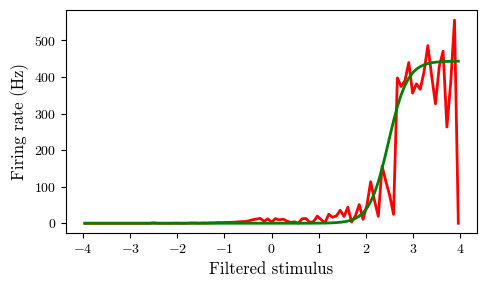

In [44]:
# plot the nonlinearity
plot(x,[N/0.001,func(x,*popt)/0.001],
    xlabel='Filtered stimulus',
    ylabel='Firing rate (Hz)',);

Interesting nonlinearity:
- Very high threshold, about 2.5 std devs of the stimulus
- Pretty steep slope, 10-90% in about 0.8 std dev
- High maximal rate: spike probability of ~0.5 in a 1 ms bin